In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam

In [2]:
data = np.loadtxt("/content/robot_inverse_kinematics_dataset.csv", skiprows=1, delimiter=',')
print(data.shape)
print(type(data))

(15000, 9)
<class 'numpy.ndarray'>


In [3]:
# Split the input and output variables
q = data[:, :6] # Joint angles
xyz = data[:, 6:] # End-effector position

scaler = MinMaxScaler()
q_scaled = scaler.fit_transform(q)
xyz_scaled = scaler.fit_transform(xyz)

# Split data into training and validation sets
q_train, q_val, xyz_train, xyz_val = train_test_split(q_scaled, xyz_scaled, test_size=0.2, random_state=42) #test_size->20% of the data is used for testing
                                                                                                            #random_state=42 -> we get the same train and test sets across different executions

# Print shapes of training and validation sets
print('Training set shapes:')
print('q_train:', q_train.shape)
print('xyz_train:', xyz_train.shape)

print('\nValidation set shapes:')
print('q_val:', q_val.shape)
print('xyz_val:', xyz_val.shape)

Training set shapes:
q_train: (12000, 6)
xyz_train: (12000, 3)

Validation set shapes:
q_val: (3000, 6)
xyz_val: (3000, 3)


In [5]:
# Define the LSTM network architecture
model = Sequential()
model.add(LSTM(64, input_shape=(6, 1), return_sequences=True))
#input_shape->(6, 1): to indicate that the input to the layer has 6 time steps (corresponding to the dofs of the robot manipulator) and 1 feature (corresponding to the joint angle value)
#return the full sequence of output values, not just the last output value.
model.add(LSTM(64))
model.add(Dense(3))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(q_train.reshape(q_train.shape[0], q_train.shape[1], 1),
                    xyz_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(q_val.reshape(q_val.shape[0], q_val.shape[1], 1), xyz_val))

Epoch 1/100
375/375 [==============================] - 14s 26ms/step - loss: 0.0404 - val_loss: 0.0331
Epoch 2/100
375/375 [==============================] - 8s 21ms/step - loss: 0.0331 - val_loss: 0.0321
Epoch 3/100
375/375 [==============================] - 5s 13ms/step - loss: 0.0310 - val_loss: 0.0295
Epoch 4/100
375/375 [==============================] - 4s 11ms/step - loss: 0.0273 - val_loss: 0.0265
Epoch 5/100
375/375 [==============================] - 4s 11ms/step - loss: 0.0246 - val_loss: 0.0238
Epoch 6/100
375/375 [==============================] - 5s 14ms/step - loss: 0.0230 - val_loss: 0.0227
Epoch 7/100
375/375 [==============================] - 4s 11ms/step - loss: 0.0222 - val_loss: 0.0223
Epoch 8/100
375/375 [==============================] - 4s 11ms/step - loss: 0.0217 - val_loss: 0.0221
Epoch 9/100
375/375 [==============================] - 5s 14ms/step - loss: 0.0214 - val_loss: 0.0216
Epoch 10/100
375/375 [==============================] - 4s 11ms/step - loss: 0.02

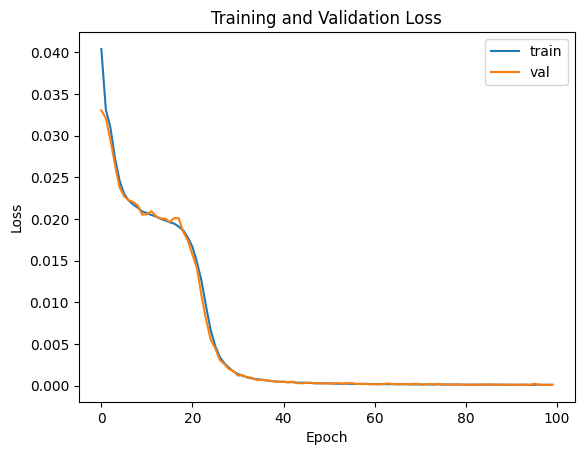

In [6]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
# Define the FNN network architecture
model_fnn = Sequential()
model_fnn.add(Dense(64, input_dim=6, activation='relu'))
model_fnn.add(Dense(32, activation='relu'))
model_fnn.add(Dense(16, activation='relu'))
model_fnn.add(Dense(3))

# Compile the model
model_fnn.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history_fnn = model_fnn.fit(q_train, xyz_train,
                            epochs=100,
                            batch_size=32,
                            validation_data=(q_val, xyz_val))

# Evaluate the model
loss_fnn = model_fnn.evaluate(q_val, xyz_val, verbose=0)
print(f'FNN validation loss: {loss_fnn:.4f}')

Epoch 1/100
375/375 [==============================] - 5s 12ms/step - loss: 0.0483 - val_loss: 0.0257
Epoch 2/100
375/375 [==============================] - 3s 8ms/step - loss: 0.0230 - val_loss: 0.0204
Epoch 3/100
375/375 [==============================] - 3s 8ms/step - loss: 0.0181 - val_loss: 0.0166
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0144 - val_loss: 0.0126
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0114 - val_loss: 0.0102
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 8/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 9/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 10/100
375/375 [==============================] - 1s 4ms/step - loss: 0.0053 - val_l

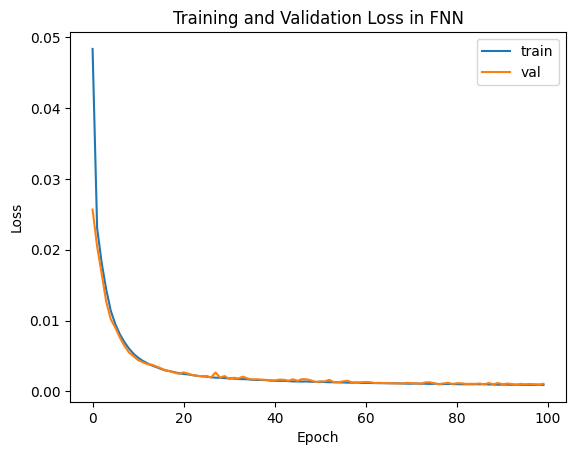

In [8]:
plt.plot(history_fnn.history['loss'], label='train')
plt.plot(history_fnn.history['val_loss'], label='val')
plt.title('Training and Validation Loss in FNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Define and train a simple recurrent neural network
rnn_model = Sequential()
rnn_model.add(SimpleRNN(64, input_shape=(6, 1), activation='relu'))
rnn_model.add(Dense(3))

rnn_model.compile(loss='mean_squared_error', optimizer=Adam())
rnn_history = rnn_model.fit(q_train.reshape(q_train.shape[0], q_train.shape[1], 1),
                            xyz_train,
                            epochs=100,
                            batch_size=32,
                            validation_data=(q_val.reshape(q_val.shape[0], q_val.shape[1], 1), xyz_val))

Epoch 1/100
375/375 [==============================] - 3s 5ms/step - loss: 0.0343 - val_loss: 0.0239
Epoch 2/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0199 - val_loss: 0.0165
Epoch 3/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0146 - val_loss: 0.0128
Epoch 4/100
375/375 [==============================] - 2s 7ms/step - loss: 0.0118 - val_loss: 0.0108
Epoch 5/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0099 - val_loss: 0.0090
Epoch 6/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0084 - val_loss: 0.0075
Epoch 7/100
375/375 [==============================] - 2s 4ms/step - loss: 0.0072 - val_loss: 0.0080
Epoch 8/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 9/100
375/375 [==============================] - 2s 4ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 10/100
375/375 [==============================] - 2s 4ms/step - loss: 0.0052 - val_lo

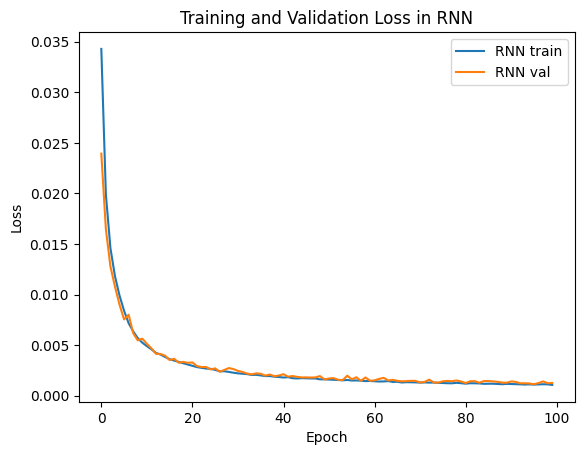

In [10]:
plt.plot(rnn_history.history['loss'], label='RNN train')
plt.plot(rnn_history.history['val_loss'], label='RNN val')
plt.title('Training and Validation Loss in RNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()